# Train a Neural Network with/without batch normalization

Margin with normalization will be shown along the training. 

Plan to extend this code to CIFAR10 for understanding batchnormalization with/wo in terms of (normalized) margin. 

In [1]:
__author__ = 'huangyf'

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
class Net(nn.Module):
    def __init__(self, hidden_size=5,with_bn=False):
        super(Net, self).__init__()
        self.with_bn=with_bn
        self.fc1 = nn.Linear(2, hidden_size, bias=False)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1, bias=False)

        for name, param in self.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.)
            elif 'weight' in name:
                nn.init.normal_(param, mean=0., std=0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        if self.with_bn:
            x = self.bn(x)  ## YY: what does it do in prediction or test?
        x = self.fc2(x)
        return x

In [3]:
class LossFunction(object):
    def __init__(self, mode='log'):
        '''
        :param mode:'log','exp','square'
        '''
        self.mode = mode

    def __call__(self, input, target):
        if self.mode == 'log':
            loss = (1 + torch.exp(-input * target.float())).log().mean()
        elif self.mode == 'exp':
            loss = (-input * target.float()).exp().mean()
        elif self.mode == 'square':
            loss = torch.mean((1 - input * target.float()) ** 2)
        return loss

The experiment without batch normalisation

In [4]:
# %%
net = Net(hidden_size=10,with_bn=False).cuda()
criterion = LossFunction(mode='exp')
optimizer = optim.SGD(net.parameters(), lr=0.1)

data = np.loadtxt('./data_nonsep.txt')
logger = {'epoch': [],
          'loss': [],
          'acc': [],
          'w1_fro': [],
          'w2_l2': [],
          'margin': [],
          'normalised_margin': []}

for epoch in range(10000):
    X, Y = data[:, 1:], data[:, 0]
    input = Variable(torch.from_numpy(X).float().cuda())
    label = Variable(torch.from_numpy(Y).long().cuda()).view(-1, 1)
    output = net.forward(input)
    prediction = np.where(output.squeeze().cpu().data.numpy() > 0, 1, -1)
    acc = np.mean(prediction == label.squeeze().cpu().data.numpy())
    loss = criterion(output, label)

    logger['epoch'].append(epoch)
    logger['loss'].append(loss.item())
    logger['acc'].append(acc)
    logger['w1_fro'].append(np.sqrt(torch.sum(net.fc1.weight ** 2).item()))
    logger['w2_l2'].append(net.fc2.weight.norm(2).item())
    logger['margin'].append(torch.min(output * label.float()).item())
    logger['normalised_margin'].append(logger['margin'][-1] / (logger['w1_fro'][-1] * logger['w2_l2'][-1]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('{}/{} loss:{:.4f} acc:{:.4f} w1_norm:{:.4f} w2_norm:{:.4f} margin:{:.4f} normal_margin:{:.4f}'.format(
            epoch, 10000, loss.item(), acc,
            logger['w1_fro'][-1], logger['w2_l2'][-1], logger['margin'][-1], logger['normalised_margin'][-1]))

0/10000 loss:0.9978 acc:0.5000 w1_norm:0.6072 w2_norm:0.2637 margin:-0.0258 normal_margin:-0.1613
100/10000 loss:0.2450 acc:1.0000 w1_norm:2.0816 w2_norm:2.0093 margin:0.1476 normal_margin:0.0353
200/10000 loss:0.1284 acc:1.0000 w1_norm:2.7992 w2_norm:2.7445 margin:0.6310 normal_margin:0.0821
300/10000 loss:0.0806 acc:1.0000 w1_norm:3.2572 w2_norm:3.2099 margin:1.1906 normal_margin:0.1139
400/10000 loss:0.0556 acc:1.0000 w1_norm:3.5929 w2_norm:3.5500 margin:1.5388 normal_margin:0.1206
500/10000 loss:0.0410 acc:1.0000 w1_norm:3.8512 w2_norm:3.8111 margin:1.7870 normal_margin:0.1217
600/10000 loss:0.0317 acc:1.0000 w1_norm:4.0576 w2_norm:4.0196 margin:1.9940 normal_margin:0.1223
700/10000 loss:0.0254 acc:1.0000 w1_norm:4.2274 w2_norm:4.1910 margin:2.1824 normal_margin:0.1232
800/10000 loss:0.0210 acc:1.0000 w1_norm:4.3706 w2_norm:4.3354 margin:2.3489 normal_margin:0.1240
900/10000 loss:0.0178 acc:1.0000 w1_norm:4.4937 w2_norm:4.4594 margin:2.4978 normal_margin:0.1246
1000/10000 loss:0.01

8300/10000 loss:0.0009 acc:1.0000 w1_norm:6.3184 w2_norm:6.2941 margin:5.3692 normal_margin:0.1350
8400/10000 loss:0.0009 acc:1.0000 w1_norm:6.3263 w2_norm:6.3020 margin:5.3843 normal_margin:0.1351
8500/10000 loss:0.0008 acc:1.0000 w1_norm:6.3341 w2_norm:6.3098 margin:5.3992 normal_margin:0.1351
8600/10000 loss:0.0008 acc:1.0000 w1_norm:6.3418 w2_norm:6.3175 margin:5.4139 normal_margin:0.1351
8700/10000 loss:0.0008 acc:1.0000 w1_norm:6.3493 w2_norm:6.3251 margin:5.4285 normal_margin:0.1352
8800/10000 loss:0.0008 acc:1.0000 w1_norm:6.3568 w2_norm:6.3326 margin:5.4429 normal_margin:0.1352
8900/10000 loss:0.0008 acc:1.0000 w1_norm:6.3642 w2_norm:6.3400 margin:5.4571 normal_margin:0.1352
9000/10000 loss:0.0008 acc:1.0000 w1_norm:6.3715 w2_norm:6.3473 margin:5.4711 normal_margin:0.1353
9100/10000 loss:0.0008 acc:1.0000 w1_norm:6.3787 w2_norm:6.3546 margin:5.4850 normal_margin:0.1353
9200/10000 loss:0.0008 acc:1.0000 w1_norm:6.3858 w2_norm:6.3617 margin:5.4987 normal_margin:0.1354
9300/10000

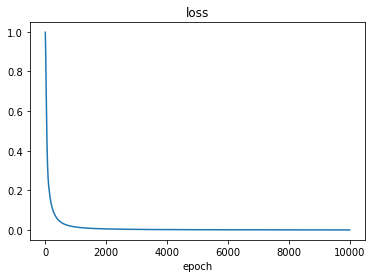

In [5]:
# %%
# x, y = np.argmax(logger['acc']), np.max(logger['acc'])
plt.figure(0)
plt.title('loss')
# plt.plot(x, logger['loss'][x], 'rx')
plt.plot(logger['loss'])
plt.xlabel('epoch')
plt.show()

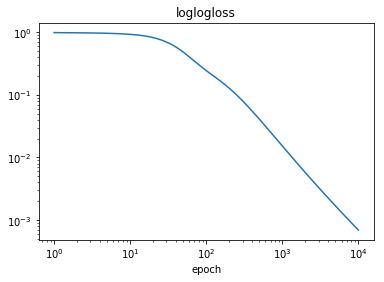

In [6]:
plt.figure(1)
plt.title('loglogloss')
plt.loglog(logger['loss'])
plt.xlabel('epoch')
plt.show()

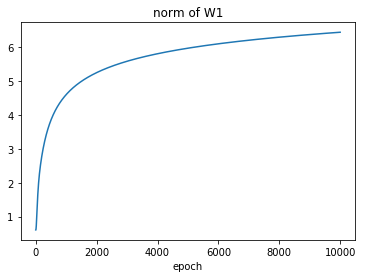

In [7]:
plt.figure(2)
plt.title('norm of W1')
plt.plot(logger['w1_fro'])
plt.xlabel('epoch')
plt.show()

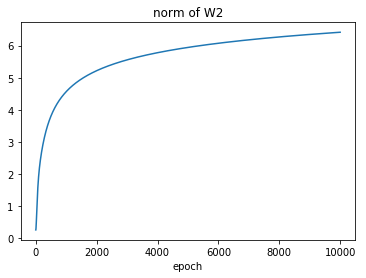

In [8]:
plt.figure(3)
plt.title('norm of W2')
plt.plot(logger['w2_l2'])
plt.xlabel('epoch')
plt.show()

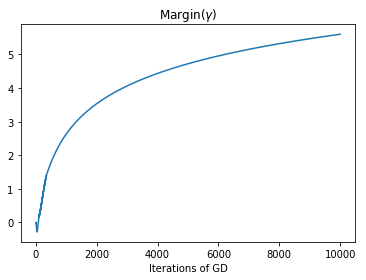

In [9]:
plt.figure(4)
plt.title('Margin($\gamma$)')
plt.plot(logger['margin'])
plt.xlabel('Iterations of GD')
plt.show()

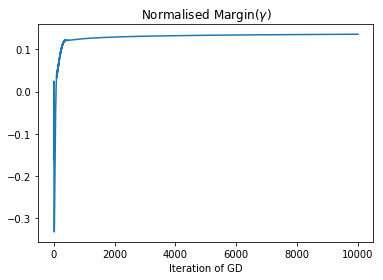

In [10]:
plt.figure(5)
plt.title('Normalised Margin($\gamma$)')
plt.plot(logger['normalised_margin'])
# plt.plot(x, y, 'rx')
# plt.text(x + 100, y - 0.02, 'x={}'.format(x))
# plt.text(x + 100, y + 0.008, '$\gamma$={:.4f}'.format(y))
plt.xlabel('Iteration of GD')
plt.show()

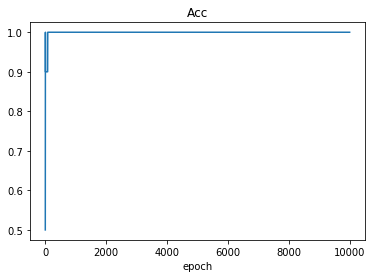

In [11]:
plt.figure(6)
plt.title('Acc')
# plt.plot(x, logger['acc'][x], 'rx')
plt.plot(logger['acc'])
plt.xlabel('epoch')
plt.show()

##########

Yifei: can you add batch normalization and retrain the network to see the improved normalized margin?

########

The experiment with batch normalisation

In [ ]:
# %%
net = Net(hidden_size=10,with_bn=True).cuda()
criterion = LossFunction(mode='exp')
optimizer = optim.SGD(net.parameters(), lr=0.1)

data = np.loadtxt('./data_nonsep.txt')
logger_bn = {'epoch': [],
          'loss': [],
          'acc': [],
          'w1_fro': [],
          'w2_l2': [],
          'margin': [],
          'normalised_margin': []}

for epoch in range(10000):
    X, Y = data[:, 1:], data[:, 0]
    input = Variable(torch.from_numpy(X).float().cuda())
    label = Variable(torch.from_numpy(Y).long().cuda()).view(-1, 1)
    output = net.forward(input) 
    prediction = np.where(output.squeeze().cpu().data.numpy() > 0, 1, -1)
    acc = np.mean(prediction == label.squeeze().cpu().data.numpy())
    loss = criterion(output, label)

    logger_bn['epoch'].append(epoch)
    logger_bn['loss'].append(loss.item())
    logger_bn['acc'].append(acc)
    logger_bn['w1_fro'].append(np.sqrt(torch.sum(net.fc1.weight ** 2).item())) 
    #? dividing? running std and batch normalization parameter gamma in test data, perhaps tells us what BN does for network
    ## find running mean/Variance and Gamma, Betta in models
    ## is the ratio Gamma/SQRT(Var) close to 1?
    ## Then we can try net.eval() to reevaluate the model prediction on the 10 points.
    logger_bn['w2_l2'].append(net.fc2.weight.norm(2).item())
    logger_bn['margin'].append(torch.min(output * label.float()).item())
    logger_bn['normalised_margin'].append(logger_bn['margin'][-1] / (logger_bn['w1_fro'][-1] * logger_bn['w2_l2'][-1]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # net.eval()
    # 
    if epoch % 100 == 0:
        print('{}/{} loss:{:.4f} acc:{:.4f} w1_norm:{:.4f} w2_norm:{:.4f} margin:{:.4f} normal_margin:{:.4f}'.format(
            epoch, 10000, loss.item(), acc,
            logger_bn['w1_fro'][-1], logger_bn['w2_l2'][-1], logger_bn['margin'][-1], logger_bn['normalised_margin'][-1]))

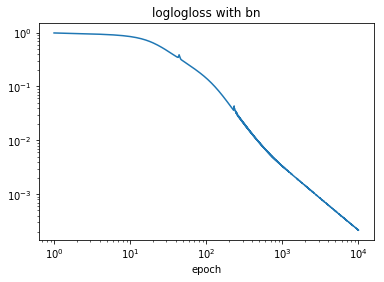

In [13]:
plt.figure(1)
plt.title('loglogloss with bn')
plt.loglog(logger_bn['loss'])
plt.xlabel('epoch')
plt.show()

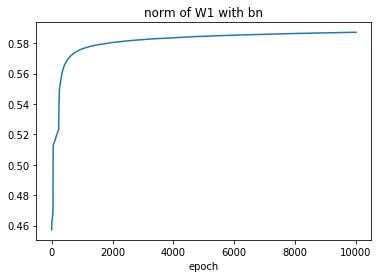

In [14]:
plt.figure(2)
plt.title('norm of W1 with bn')
plt.plot(logger_bn['w1_fro'])
plt.xlabel('epoch')
plt.show()

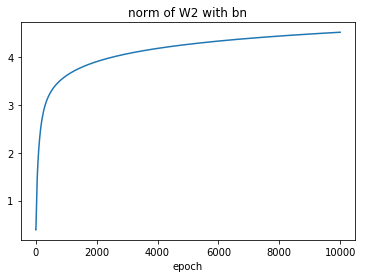

In [15]:
plt.figure(3)
plt.title('norm of W2 with bn')
plt.plot(logger_bn['w2_l2'])
plt.xlabel('epoch')
plt.show()

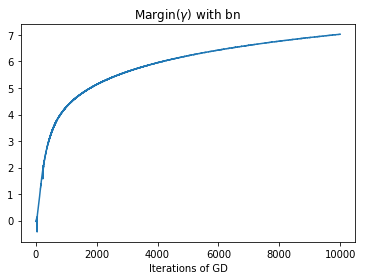

In [16]:
plt.figure(4)
plt.title('Margin($\gamma$) with bn')
plt.plot(logger_bn['margin'])
plt.xlabel('Iterations of GD')
plt.show()

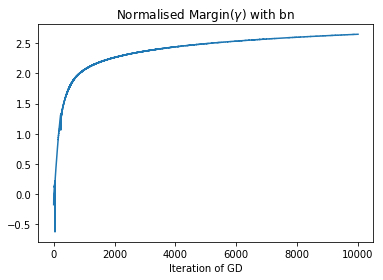

In [17]:
plt.figure(5)
plt.title('Normalised Margin($\gamma$) with bn')
plt.plot(logger_bn['normalised_margin'])
plt.xlabel('Iteration of GD')
plt.show()

We can see that the normalised margin had been greatly improved after batch normalisation